In [2]:
import sys
sys.path.append('../Codes/library/')
sys.path.append('../Codes/Python/')
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import scipy.special as sc
import pandas as pd
from Immuno_models import*
N_A = 6.02214076e23
Text_files_path = '/Users/robertomorantovar/Dropbox/Research/Evolution_Immune_System/Text_files/'

%autosave 60

Autosaving every 60 seconds


In [3]:
N_r = 5e4
T0 = 0
Tf = 6
dT = .01
days = np.arange(0, Tf, 1)
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
time_bins = time[::10]
lambda_A = 6 #days^-1
k_pr = .1 # hour^-1
k_pr = k_pr*24 #days^-1
qs = [1, 2, 3]
colors_q = ['darkred', 'olive', 'navy']
lambda_B = 1*lambda_A
k_on = 1e6*24*3600; #(M*days)^-1
N_c = 1e3
E_ms = -27

E_t = lambda t, q:lambda_A*t/q - np.log((lambda_A*N_A)/(k_on*N_c))/q + np.log(k_pr/k_on) 

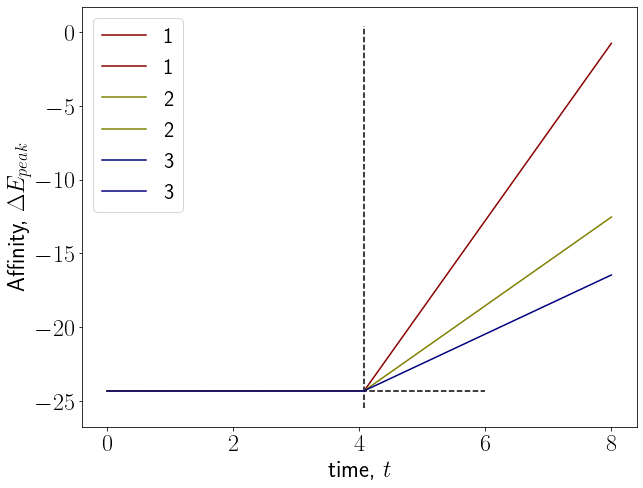

In [4]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.95, 'bottom':.15})
t_prime = 1/lambda_A*np.log((lambda_A*N_A)/(k_on*N_c))
time1 = np.linspace(0, t_prime, 100)
time2 = np.linspace(t_prime, 8, 100)
for q in qs:
    ax.plot(time1, np.ones_like(time1)*E_t(t_prime, q) , label = '%d'%q, color = colors_q[q-1])
    ax.plot(time2, E_t(time2, q) , label = '%d'%q, color = colors_q[q-1])
    

ax.vlines(t_prime, ax.get_ylim()[0], ax.get_ylim()[1], color = 'black', linestyle = '--')
ax.hlines(np.log(k_pr/k_on), time[0], time[-1], color = 'black', linestyle = '--')
ax.legend(fontsize = 22)
my_plot_layout(ax=ax, xlabel = r'time, $t$', ylabel = r'Affinity, $\Delta E_{peak}$')


(-26.094667468978344, -10.0)

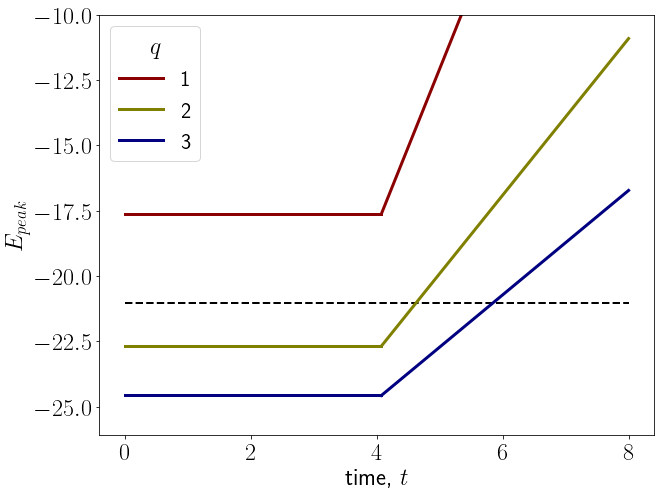

In [5]:
fig, ax = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.95, 'bottom':.15})
E_q = [-17.62, -22.68, -24.57]
for i, q in enumerate(qs):
    deltaE = E_t(time2, q) - E_t(t_prime, q)
    ax.plot(time1, np.ones_like(time1)*E_q[i], color = colors_q[i], linewidth = 3)
    ax.plot(time2, E_q[i]+deltaE, label = '%d'%q, color = colors_q[i], linewidth = 3)

#ax.vlines(t_prime, ax.get_ylim()[0], ax.get_ylim()[1], color = 'black', linestyle = '--')
ax.hlines(-21.03, time1[0], time2[-1], color = 'black', linestyle = '--', linewidth = 2)
ax.legend(fontsize = 22, title = r'$q$', title_fontsize = 24)
my_plot_layout(ax=ax, xlabel = r'time, $t$', ylabel = r'$E_{peak}$')
ax.set_ylim(top = -10)

In [51]:
M1 = np.loadtxt(Text_files_path+'MJ.txt', skiprows= 1, usecols=range(1,21)).tolist()
M2 = (np.loadtxt(Text_files_path+'MJ2.txt', skiprows= 1, usecols=range(1,21))).tolist()
M3 = np.loadtxt(Text_files_path+'BLOSUM62.txt', skiprows= 1, max_rows = 23, usecols=range(1,24)).tolist()
Alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
Alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']
Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)

Matrix = 'MJ2'
#Matrix = 'MM'

if(Matrix == 'MJ2'):
    M2 = np.loadtxt(Text_files_path + Matrix + '.txt', skiprows= 1, usecols=range(1,21))
    Alphabet = np.loadtxt(Text_files_path + 'Alphabet.txt', dtype=bytes, delimiter='\t').astype(str)
    Alphabet_list = Alphabet.tolist()

colors = ['tab:blue','tab:red']
N_ens = 500
N_rs = np.logspace(3.6, 9, 20)
T0 = 0
Tf = 9
dT = .01
days = np.arange(0, Tf, 1)
time = np.linspace(T0, Tf, int((Tf-T0)/dT))
time_bins = time[::5]
lambda_A = 6 #days^-1
k_pr = .1 # hour^-1
k_pr = k_pr*24 #days^-1
qs = np.linspace(1, 4, 10)
lambda_B = 1*lambda_A
k_on = 1e6*24*3600; #(M*days)^-1
N_c = 1e3
E_ms = -27

antigen = 'TACNSEYPNTTK'
L=len(antigen)

#----------------------------------------------------------------

antigen_list = [i for i in antigen]
antigen_seq = np.array([], dtype = int)
for i, aa in enumerate(antigen_list):
    index = Alphabet_list.index(aa)
    antigen_seq = np.append(antigen_seq, int(index))
PWM_data = M2[:,antigen_seq]

#Change values by the minimum
for i in np.arange(L):
    PWM_data[:,i]-=np.min(PWM_data[:,i], axis=0)

Es, dE, Q0, lambdas = calculate_Q0(0.01, 50, PWM_data, E_ms, L)
S = np.cumsum(lambdas[:-1]*dE)
Omega = np.sum(np.exp(S)*dE)
Ks = np.exp(Es[:-1])

beta_pr = lambdas[:-1][Es[:-1]<np.log(k_pr/k_on)][-1]
E_pr = Es[:-1][Es[:-1]<np.log(k_pr/k_on)][-1]
print('E_pr:%.2f'%E_pr, 'beta_pr:%.2f'%beta_pr)

beta_r = lambdas[:-1][np.cumsum(Q0*dE)<(1/N_r)][-1]
E_r = Es[:-1][np.cumsum(Q0*dE)<(1/(N_r))][-1]
print('E_r:%.2f'%E_r, 'beta_r:%.2f'%beta_r)

#----------------------------------------------------------------
t_act = [3.8, 4.5]

energy_model = 'MJ'




E_pr:-24.31 beta_pr:2.81
E_r:-25.06 beta_r:3.50


In [52]:
times_act = np.zeros((len(N_rs), len(qs)))
Es_act = np.zeros_like(times_act)
betas_act = np.zeros_like(times_act)

Es_q = np.zeros(len(qs))
Es_r = np.zeros(len(N_rs))

betas_q = np.zeros(len(qs))
betas_r = np.zeros(len(N_rs))

for i_N_r, N_r in enumerate(N_rs):
    beta_r = lambdas[:-1][np.cumsum(Q0*dE)<(1/N_r)][-1]
    E_r = Es[:-1][np.cumsum(Q0*dE)<(1/(N_r))][-1]
    Es_r[i_N_r] = E_r
    betas_r[i_N_r] = beta_r
    for i_q, q in enumerate(qs):
        beta_q = lambdas[lambdas>q][-1]
        E_q = Es[lambdas>q][-1]
        Es_q[i_q] = E_q
        betas_q[i_q] = beta_q
        u_on, p_a, R, QR = calculate_QR(Q0, k_on, k_pr, np.exp(lambda_A*Tf)/N_A, Es, q, lambda_A, N_c, dE)

        m_bar2 = np.array([N_r*(np.sum((1-np.exp(-(np.exp(lambda_A*t)/N_A)*k_on*p_a*N_c/lambda_A))*Q0*dE)) for t in time])

        t_act_theory = time[m_bar2>1][0]
        
        times_act[i_N_r, i_q] = t_act_theory
        Es_act[i_N_r, i_q] = np.max([E_q, E_r])
        betas_act[i_N_r, i_q] = np.min([beta_r, beta_q])

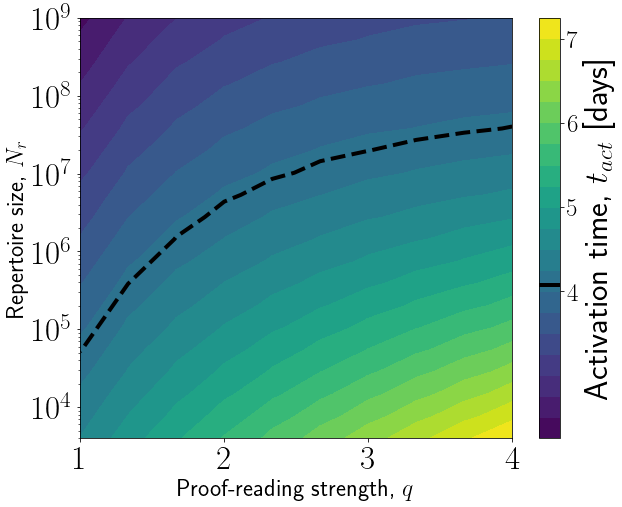

In [53]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
X, Y = np.meshgrid(qs, N_rs)
Z = X*Y
cs = AX.contourf(X, Y, times_act, levels = 20, cmap =plt.cm.viridis)
cs2 = AX.contour(cs, levels=[1/lambda_A*np.log((N_A*lambda_A)/(k_on*N_c))], colors='k', linestyles = 'dashed', linewidths = 4)
cbar = plt.colorbar(cs)
cbar.set_label('Activation time, $t_{act}$ [days]', fontsize = 33)
cbar.set_ticks(np.arange(4, Tf-1))
#cbar.set_ticklabels(np.flip(np.linspace(0,1,5)))
cbar.ax.tick_params(labelsize = 25)
cbar.add_lines(cs2)
my_plot_layout(ax=AX, xlabel = r'Proof-reading strength, $q$', ylabel = r'Repertoire size, $N_r$', yscale = 'log', ticks_labelsize = 33)
FIG.savefig('../Figures/7_Recognition/activation_time.pdf')


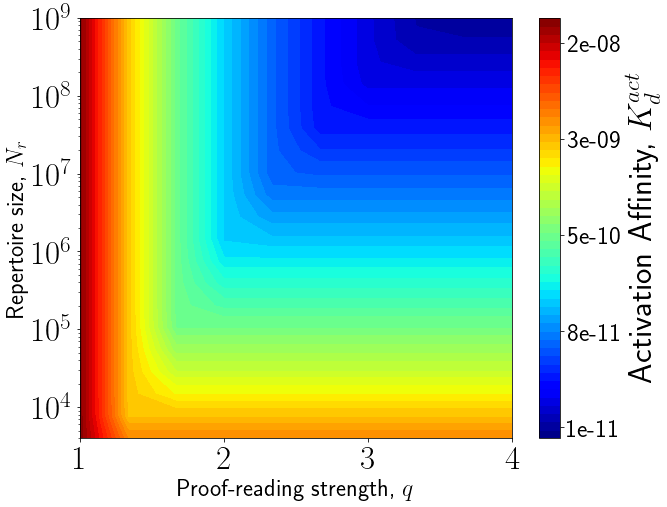

In [63]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
cs = AX.contourf(X, Y, Es_act, levels = 50, cmap =plt.cm.jet)
#s2 = AX.contour(cs, levels=Es_q, linestyles = ':', linewidths = 4)
cbar = plt.colorbar(cs)
cbar.set_label('Activation Affinity, $K_{d}^{act}$', fontsize = 33)
cbar.set_ticks(np.linspace(-25, -18, 5))
cbar.set_ticklabels(['%.0e'%i for i in np.exp(np.linspace(-25, -18, 5))])
cbar.ax.tick_params(labelsize = 25)
#cbar.add_lines(cs2)
my_plot_layout(ax=AX, xlabel = r'Proof-reading strength, $q$', ylabel = r'Repertoire size, $N_r$', yscale = 'log', ticks_labelsize = 33)
FIG.savefig('../Figures/7_Recognition/activation_energy.pdf')


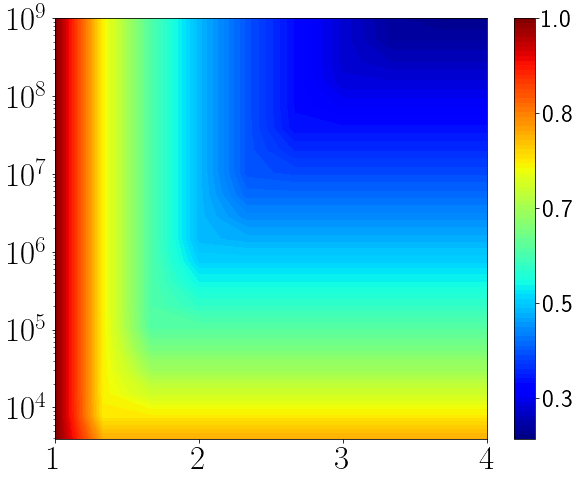

In [69]:
FIG, AX = plt.subplots(figsize=(10,8), gridspec_kw={'left':0.18, 'right':.93, 'bottom':.15})
cs = AX.contourf(X, Y, 1/betas_act, levels = 100, cmap =plt.cm.jet)
#cs2 = AX.contour(cs, levels=1/np.arange(1, 5), linestyles = '--', linewidths = 4, colors = 'k')
#cs2 = AX.contour(cs, levels=1/betas_r[::5], linestyles = ':', linewidths = 4)
cbar = plt.colorbar(cs)
#cbar.set_label('Activation temperature, $[T/T_{0}]$', fontsize = 33)
cbar.set_ticks(np.linspace(.35, 1, 5))
cbar.set_ticklabels(['%.1f'%(i) for i in np.linspace(.35, 1, 5)])
cbar.ax.tick_params(labelsize = 25)

#cbar.add_lines(cs2)
my_plot_layout(ax=AX, yscale = 'log', ticks_labelsize = 33)
FIG.savefig('../Figures/7_Recognition/activation_temperature.pdf')
